### Niwot Ridge, Colorado, USA

**Station name:** nwot

**Location:** [Niwot Ridge LTER](https://nwt.lternet.edu)

**Archive:** [UNAVCO](https://www.unavco.org)

**Ellipsoidal Coordinates:**

- Latitude: 40.05539 

- Longitude: -105.59053

- Height(m): 3522.729 

[UNAVCO station page](https://www.unavco.org/instrumentation/networks/status/nota/overview/NWOT)



<img src="https://www.unavco.org/data/gps-gnss/lib/images/station_images/NWOT.jpg" width=500/>


### Data Summary
Station nwot was originally installed/designed to support GPS reflections research. The site was hosted by the Niwot Ridge LTER.

nwot was made to be taller than the typical geodetic antenna so that it would not be buried by snow. It is about 3 meters above the bare soil surface. Because it was installed to support testing GPS reflections, nwot has always tracked L2C.

For this example, we will focus on the data between 2009-2015.

### Imports

In [1]:
import os
import sys
import re
import json
import pandas as pd 
import numpy as np
import seaborn as sns; sns.set_theme(style="whitegrid");
import matplotlib.pyplot as plt
import datetime

# We are including our repository bin to the system path so that we can import the following python modules
bin_path = os.path.abspath(os.path.join('../../bin'))
if bin_path not in sys.path:
    sys.path.append(bin_path)
    
import run_gnssrefl 
import gnssrefl_helpers

%matplotlib inline

In [2]:
#Making sure environment variables are set
exists = gnssrefl_helpers.check_environment()
if exists == False:
    gnssrefl_helpers.set_environment()
else:
     print('environment variable ORBITS path is:\n', os.environ['ORBITS'],
          '\nenvironment variable REFL_CODE path is:\n', os.environ['REFL_CODE'],
          '\nenvironment variable EXE path is:\n', os.environ['EXE'])
        
refl_code_loc = os.environ['REFL_CODE']
# import the crx2rnx file which is dependant on your working OS - this is required to run the gnssrefl code
gnssrefl_helpers.download_crx2rnx()

environment variable ORBITS set to path /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/orbits 
environment variable REFL_CODE set to path /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter 
environment variable EXE set to path /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/bin/exe


In [3]:
# This is only for these use cases 
# you can set pltscreen=True in quicklook to print these plots as well

def pretty_plots(station, values, frequency,metrics=None):
    # plotting the quicklook graph periodograms
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,10), sharex=True)
    fig.suptitle(f'QuickLook: {station},{frequency}', size=16)

    quadrants = ['NW', 'NE', 'SW', 'SE']
    quadrant_labels = ['Northwest','Northeast', 'Southwest', 'Southeast']

    for i, ax in enumerate(axes.flat):
        quad = quadrants[i]
        for fail_satellite in values[f'f{quad}']:
            g = sns.lineplot(x=values[f'f{quad}'][fail_satellite][0],
                             y=values[f'f{quad}'][fail_satellite][1],
                             ax=ax, color='lightgrey')
        for satellite in values[quad]:
            g = sns.lineplot(x=values[quad][satellite][0],
                             y=values[quad][satellite][1],
                             ax=ax)
        g.set_title(quadrant_labels[i])
        g.set_ylabel('volts/volts')
        g.set_xlabel('reflector height (m)')

    if metrics:
        success, fail = gnssrefl_helpers.quicklook_metrics(metrics)
        fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(10,10), sharex=True)
        fig.suptitle(f'QuickLook Retrieval Metrics: {station}, {frequency}', size=16)

        for i, ax in enumerate(axes):
            g = sns.scatterplot(x='Azimuth',y=success.columns[i+1], data=success, ax=ax, label='good')
            g = sns.scatterplot(x='Azimuth',y=fail.columns[i+1], data=fail, ax=ax, color='lightgrey', label='bad')

        axes[0].legend(loc='upper right')

        avg_rh = np.mean(success['Reflector Height'])
        print(f'Average reflector height value: {avg_rh:.1f}')

    plt.tight_layout()
    plt.show()

### Make a SNR File and run quickLook

We will start by making a SNR file. The main archive for this dataset only provides the high-quality L2C data in the highrate (1-sec) area. We do not need this sample rate for GPS reflectometry, we will use the "special" archive option where the 1-sec data have been decimated to 15 seconds:

In [4]:
station = 'nwot'
year = 2014 
doy = 270

lat = 40.055
long = -105.591
height = 3522.449

In [5]:
run_gnssrefl.rinex2snr(station, year, doy, archive='special')

SNR file exists /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2014/snr/nwot/nwot2700.14.snr66


Now let's use this **quickLook** command to get a sense of the quality of the 
reflector height (RH) retrievals. 

First L1:

minimum elevation angle (degrees) for this dataset:  0.0005
Average reflector height value: 3.1


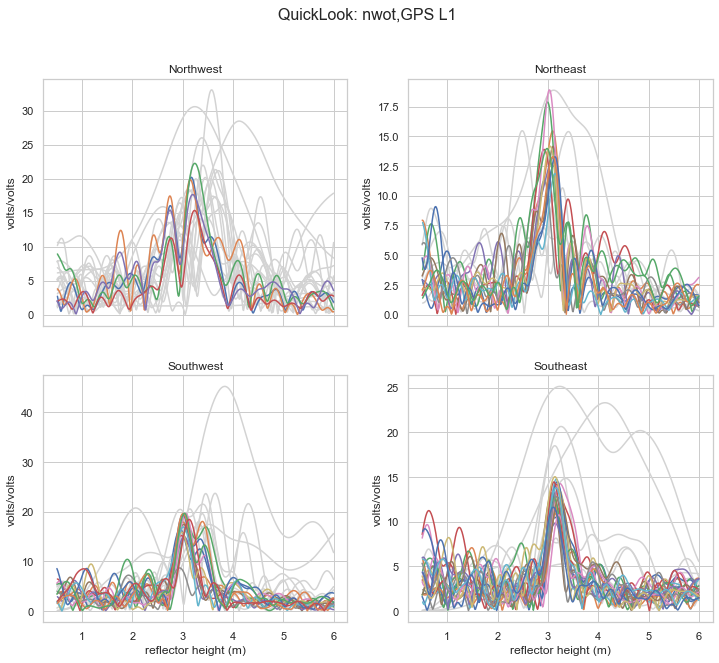

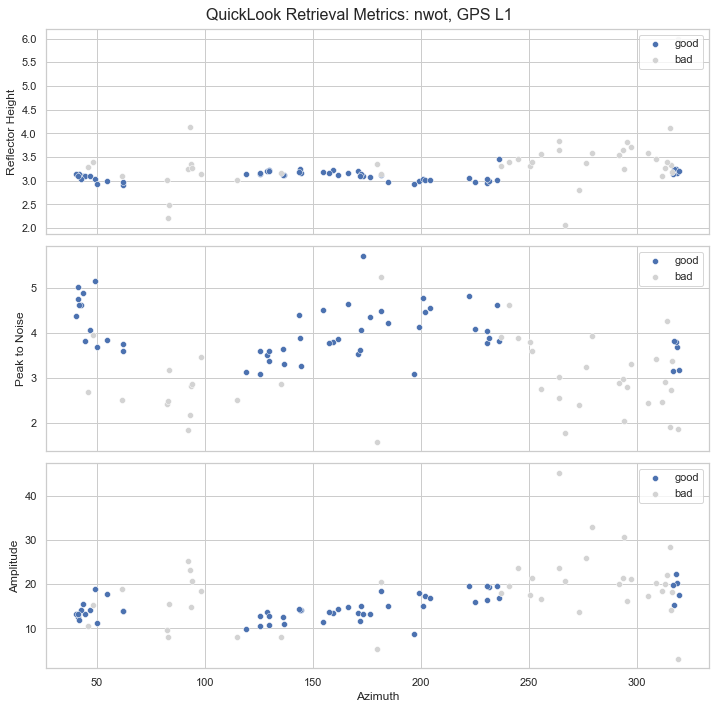

In [6]:
values, metrics = run_gnssrefl.quicklook(station, year, doy=doy)
pretty_plots(station, values, 'GPS L1', metrics)

These periodograms are a bit busy in the low RH area. But there are 
nice strong peaks in a few of the quadrants. So we can see from this that there may be some azimuth ranges that we will want to remove for teh analysis.

Now try L2:

minimum elevation angle (degrees) for this dataset:  0.0005


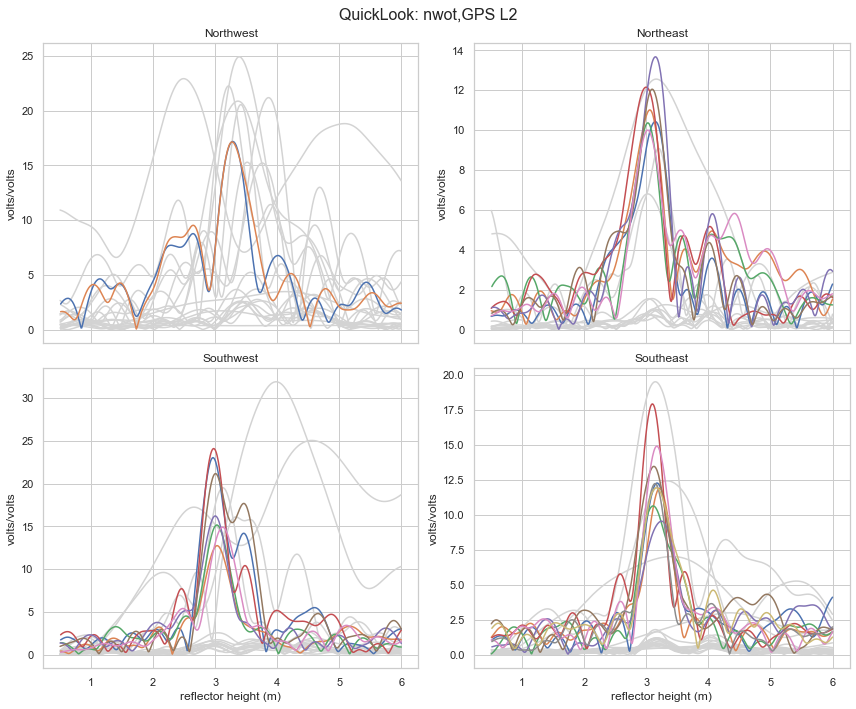

In [7]:
# Plotting using pltscreen=True
values, metrics = run_gnssrefl.quicklook(station, year, doy=doy, f=2)
pretty_plots(station, values, 'GPS L2')

This plot will have both L2C and non-L2C. There are failed tracks in the gray that are the non-L2C signals.

See L2C only:

minimum elevation angle (degrees) for this dataset:  0.0005
Average reflector height value: 3.1


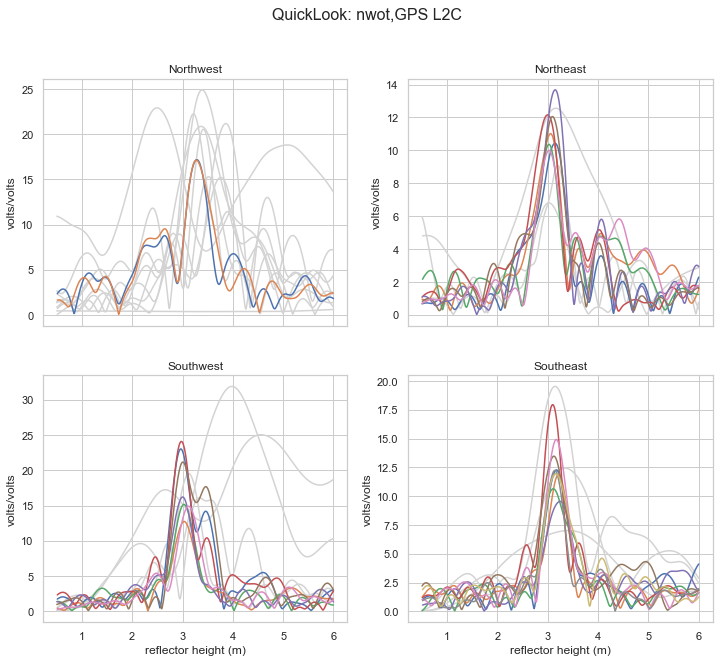

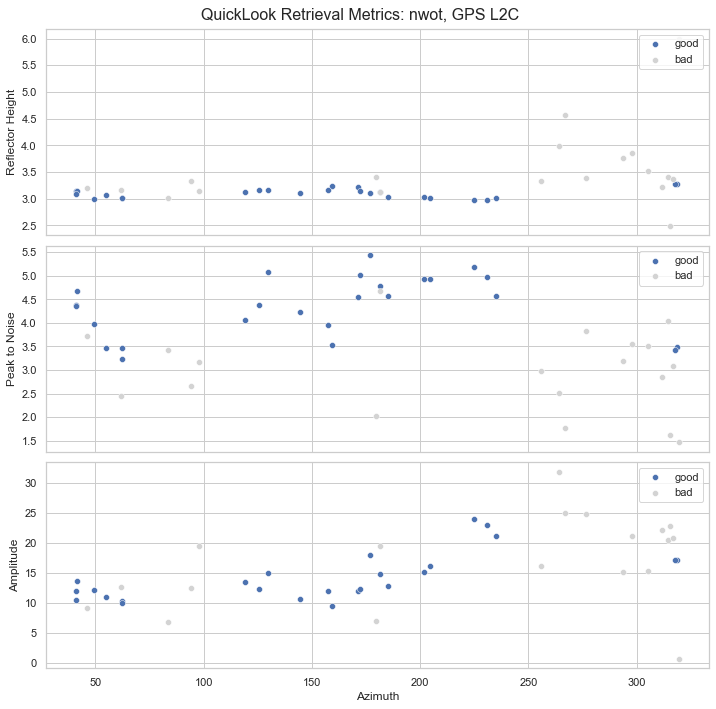

In [8]:
values, metrics = run_gnssrefl.quicklook(station, year, doy=doy, f=20)
pretty_plots(station, values, 'GPS L2C', metrics)

Those failed tracks are now gone and we will use L2C and not all of L2.

### Make multiple years of SNR files 

We are going to look at the data from installation (Fall 2009) through Spring 2015. To speed things
up I will run 2009 and 2015 separately, while the year 2010 through 2014 can be analyzed in 
one line:

In [ ]:
run_gnssrefl.rinex2snr(station, year=2009, doy=240, doy_end=365, archive='special', fortran=True)


run_gnssrefl.rinex2snr(station, year=2010, doy=1, doy_end=366, archive='special', year_end=2014, fortran=True)


run_gnssrefl.rinex2snr(station, year=2015, doy=1, doy_end=120, archive='special', fortran=True)


### Run gnssir for multiple years
Make a json file for your gnssir analysis:


We will use a peak to noise of about 3 and a spectral peak amplitude of 8. We'll also use the southern quadrants (azimuths 90 through 270). We should note that since L5 was not tracked at this site, we will not include it in the json file. Well use a minimum elevation angle of 7 degrees because this particular receiver had a limit on the number of satellites it could track.

In [9]:
run_gnssrefl.make_json(station, lat, long, height, e1=7, peak2noise=3.2, ampl=8)

writing out to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/nwot.json


In [10]:
# This is the json file that was created
json_file = '../../input/nwot.json'
with open(json_file, "r") as myfile:
    file = json.load(myfile)
file

{'station': 'nwot',
 'lat': 40.055,
 'lon': -105.591,
 'ht': 3522.449,
 'minH': 0.5,
 'maxH': 6,
 'e1': 7,
 'e2': 25,
 'NReg': [0.5, 6],
 'PkNoise': 3.2,
 'polyV': 4,
 'pele': [5, 30],
 'ediff': 2,
 'desiredP': 0.005,
 'azval': [0, 90, 90, 180, 180, 270, 270, 360],
 'freqs': [1, 20, 5],
 'reqAmp': [8, 8, 8],
 'refraction': None,
 'overwriteResults': True,
 'seekRinex': False,
 'wantCompression': False,
 'plt_screen': False,
 'onesat': None,
 'screenstats': True,
 'pltname': 'nwot_lsp.png',
 'delTmax': 75}

Now we will set our azimuth range and the frequencies manually.

In [11]:
# This is the json file that was created
json_file = '../../input/nwot.json'
with open(json_file, "r") as myfile:
    file = json.load(myfile)
    file['azval'] = [90, 180, 180, 270]
    file['freqs'] = [1,20]
os.remove(json_file)
with open(json_file, 'w') as f:
    json.dump(file, f, indent=4)
    
with open(json_file, "r") as myfile:
    file = json.load(myfile)

file

{'station': 'nwot',
 'lat': 40.055,
 'lon': -105.591,
 'ht': 3522.449,
 'minH': 0.5,
 'maxH': 6,
 'e1': 7,
 'e2': 25,
 'NReg': [0.5, 6],
 'PkNoise': 3.2,
 'polyV': 4,
 'pele': [5, 30],
 'ediff': 2,
 'desiredP': 0.005,
 'azval': [90, 180, 180, 270],
 'freqs': [1, 20],
 'reqAmp': [8, 8, 8],
 'refraction': None,
 'overwriteResults': True,
 'seekRinex': False,
 'wantCompression': False,
 'plt_screen': False,
 'onesat': None,
 'screenstats': True,
 'pltname': 'nwot_lsp.png',
 'delTmax': 75}

Run gnssir for the years 2009-2015:

In [ ]:
year = 2009
doy = 1
doy_end = 365
year_end = 2015 
plot=False
run_gnssrefl.gnssir(station, year, doy, doy_end=doy_end, year_end=year_end, plt=plot, screenstats=False)

### Compute daily average RH values
Now we will use the daily_avg utility to compute RH for each day. A median filter of 0.25 meter is used to eliminate large outliers and a minimum number of tracks will be set to 10. This is relatively low because of the small number of L2C transmitting satellites in the early years of the dataset.

In [12]:
run_gnssrefl.daily_avg(station, medfilter=.25, ReqTracks=10, year1=2009, year2=2015, plt2screen=False, txtfile='nwot-dailyavg.txt')

all RH will be written to:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/nwot_allRH.txt
Number of files in  2009 121
not enough retrievals on  2009 9 22 6
not enough retrievals on  2009 12 20 10
not enough retrievals on  2009 12 23 8
not enough retrievals on  2009 12 16 10
not enough retrievals on  2009 11 15 3
Number of files in  2010 347
not enough retrievals on  2010 7 31 10


/Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/bin/run_gnssrefl.py:852: UserWarning: loadtxt: Empty input file: "/Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2010/results/nwot//323.txt"
  a = np.loadtxt(fname, skiprows=3, comments='%').T


not enough retrievals on  2010 3 24 7
not enough retrievals on  2010 10 19 10
not enough retrievals on  2010 2 16 6
not enough retrievals on  2010 10 17 1
Number of files in  2011 365
Number of files in  2012 316
not enough retrievals on  2012 2 5 9
not enough retrievals on  2012 2 6 10
not enough retrievals on  2012 2 4 4
not enough retrievals on  2012 2 3 6
not enough retrievals on  2012 10 9 5
Number of files in  2013 365
not enough retrievals on  2013 12 19 7
Number of files in  2014 364
not enough retrievals on  2014 1 22 9
not enough retrievals on  2014 1 23 7
not enough retrievals on  2014 1 21 8
not enough retrievals on  2014 1 20 10
not enough retrievals on  2014 1 24 9
not enough retrievals on  2014 1 25 8
not enough retrievals on  2014 1 26 8
Number of files in  2015 118
Daily average RH png file saved as:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/nwot_RH.png
Daily average RH will be written to:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/nwot-dai

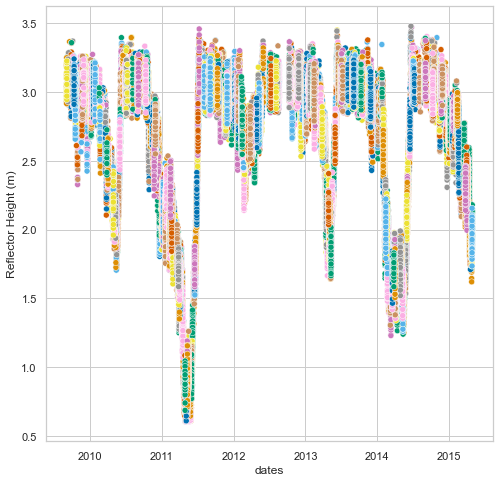

In [13]:
filepath = f'{refl_code_loc}/Files/{station}_allRH.txt'
data = gnssrefl_helpers.read_rh_files(filepath)

df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])
plt.figure(figsize=(8,8))
g = sns.scatterplot(x='dates', y='rh', data=df, hue='dates', palette='colorblind', legend=False)
g.set_ylim()
g.set_ylabel('Reflector Height (m)');

This first plot shows all of the reflector heights calculated. Next we can show the number of values used in each daily average.

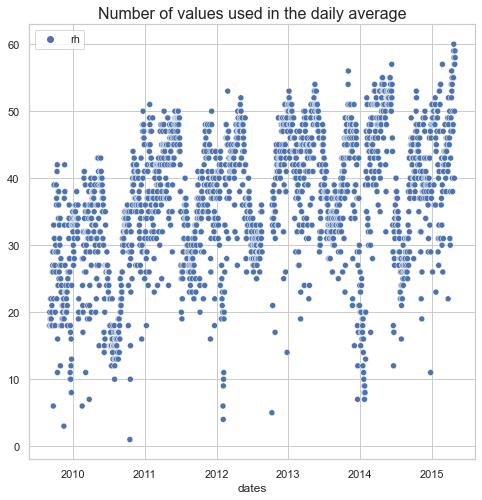

In [14]:
plt.figure(figsize=(8,8))
df_group = df.groupby(['dates']).agg(['count'])
g = sns.scatterplot(data=df_group)
g.set_title('Number of values used in the daily average', size=16);

and then we can plot the daily averages:

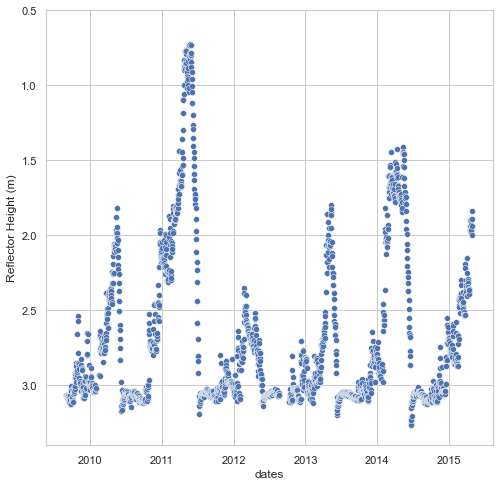

In [15]:
filepath = f'{refl_code_loc}/Files/{station}-dailyavg.txt'
data = gnssrefl_helpers.read_rh_files(filepath)
df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])

plt.figure(figsize=(8,8))
g = sns.scatterplot(x='dates', y='rh', data=df, legend=False)
g.set_ylim(3.4,.5)
g.set_ylabel('Reflector Height (m)');

The GPS site at Niwot Ridge was installed because there was a long-standing experiment 
for measuring snow depth. We therefore have a way to assess
accuracy. We download the *in situ* data from 
the [Niwot Ridge facility](https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-nwt&identifier=34) and will compare to pole 16.

<code>snow depth = RH_baresoil - RH</code>

We will make an estimate of the bare soil reflector height by taking an average of the reflector heights from august to mid september.

In [16]:
df['doy'] = pd.to_datetime(df['dates']).dt.dayofyear

# get average ground height without snow
# Using august and mid-september to determine "no snow level"
RH_baresoil = df[(df['doy']>=213) & (df['doy']<= 258)]['rh'].mean()

df['rh'] = RH_baresoil - df['rh']

We will then download the data and plot it over the same time period that we analyzed.

In [17]:
# in situ data for Niwot Ridge LTER
# https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-nwt&identifier=34
# this is the file we need - it is also stored at Kristine Larsons github.
data_path = 'https://pasta.lternet.edu/package/data/eml/knb-lter-nwt/31/18/6354b6f6c6d4ef8d6334cb3302644164'
data_path  = data_path.replace("https://","http://")
data = pd.read_csv(data_path, delimiter=',', skiprows=1, dtype='str', usecols=(3,2,4), index_col=None)

dt1 =pd.read_csv(data_path, skiprows=1, sep=",", quotechar='"',
                 names=["LTER_site", "local_site", "point_ID", "date","depth_stake","depth_n","depth_e","depth_s","depth_w","mean_depth","num_meas"],
                 parse_dates=['date'],
                 na_values={'LTER_site':['NaN'], "local_site":['NaN'], "point_ID":['NaN'], "date":['NaN'],"depth_stake":['NaN'],"depth_n":['NaN'],"depth_e":['NaN'],"depth_s":['NaN'],"depth_w":['NaN'],"mean_depth":['NaN'],"num_meas":['NaN']})


date_range = pd.date_range('2009-09-01', '2015-05-01')

insitu = dt1.loc[(dt1['date'].isin(date_range)) & (dt1['point_ID'] == 16)]
insitu['depth_stake'] = insitu['depth_stake'].astype(float)/100

per_date = insitu[['date', 'depth_stake']].groupby(by=['date']).mean()

/var/folders/ly/wmh5y80s3_s5gncbxd15mqjm0000gp/T/ipykernel_15017/863260314.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insitu['depth_stake'] = insitu['depth_stake'].astype(float)/100


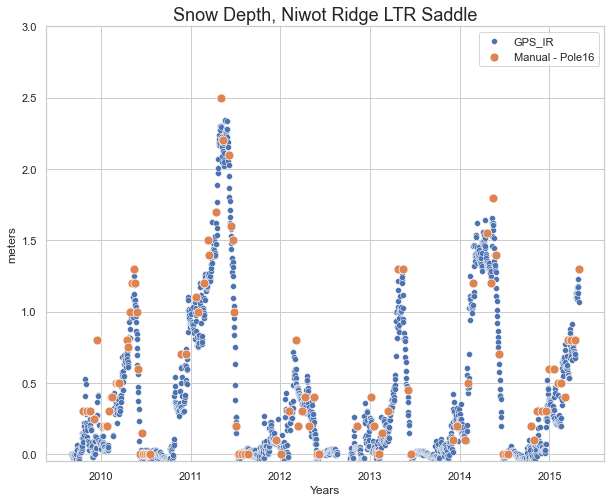

In [18]:
plt.figure(figsize=(10,8))
g = sns.scatterplot(x='dates', y='rh', data=df, legend=False, label='GPS_IR')

g2 = sns.scatterplot(x='date', y='depth_stake', data=insitu, s=80, label='Manual - Pole16')

g.set_ylabel('meters')
g.set_xlabel('Years')
g.set_title('Snow Depth, Niwot Ridge LTR Saddle', size=18)
g.set_ylim(-.05,3)


plt.show()

Citation for data:

Walker, S., J. Morse, and Niwot Ridge LTER. 2020. Snow depth data for saddle snowfence, 1992 - ongoing. ver 11. Environmental Data Initiative. [https://doi.org/10.6073/pasta/abf23758a2e5194aded95bd18c8cbf27] (Accessed 2021-10-19).


This is one of those cases where we would want to note that pole measurements are not representative of the same
footprint as the GPS measurements. As GPS measurements cover an average over a much larger region.

We do not continue with a more quantitative comparison for this demo as there are at least two 
publications in journals and a PhD Dissertation:

[Gutmann, E., K. M. Larson, M. Williams, F.G. Nievinski, and V. Zavorotny, 
Snow measurement by GPS interferometric reflectometry: an evaluation at Niwot Ridge, Colorado, Hydrologic Processes, Vol. 26, 2951-2961, 2012](https://www.kristinelarson.net/wp-content/uploads/2015/10/GutmannEtAl_2012.pdf)

[Nievinski, F.G. and K.M. Larson, Inverse Modeling of GPS Multipath for Snow Depth Estimation, Part II: Application and Validation, IEEE TGRS, Vol. 52(10), 6564-6573, doi:10.1109/TGRS.2013.2297688, 2014](https://www.kristinelarson.net/wp-content/uploads/2015/10/felipe_inv2_revised.pdf)

[Nievinski, F.G., Ph.D. Dissertation, University of Colorado, 2013](https://www.researchgate.net/publication/258848060_Forward_and_Inverse_Modeling_of_GPS_Multipath_for_Snow_Monitoring)